In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
from random import *

In [2]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
#device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce RTX 2060 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


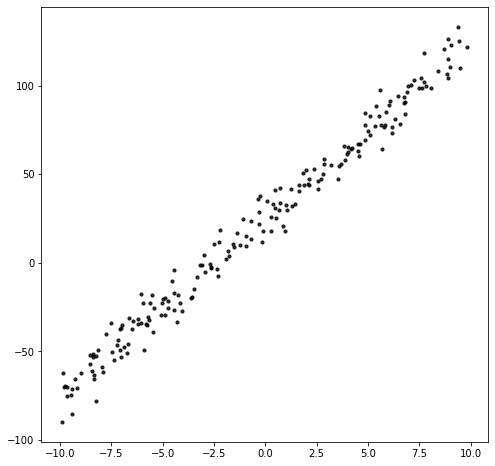

In [3]:
# Plot the input datas
path = "./data.csv"
data = np.genfromtxt(path, delimiter=',')

x_data = data[:, 0]
y_data = data[:, 1]

# Variables for plot line
min_x_data = min(x_data)
max_x_data = max(x_data)

plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.8, color='black', marker = 'o', s = 10)
plt.show()


In [4]:
# Type Initialize thetas for using torch lib.\

x_data = torch.FloatTensor(x_data).to(device)
y_data = torch.FloatTensor(y_data).to(device)
data = torch.FloatTensor(data).to(device)

In [23]:
#Linear Regression

def get_y(t0,t1,x) :
    return t0 + t1*x

# Initialize thetas for Learning : -30, -30
hth0 = torch.FloatTensor([-30.0]).to(device)
hth1 = torch.FloatTensor([-30.0]).to(device)

# Setting Step-size. (Learning-rate)
lr = 0.001

# Setting converge value
loss_conv = 1e-7 # loss converge standard

# Lists for logging
loss_log = []
hth0_log = []
hth1_log = []
epoch_log = []
conv_count = 0 # Variable To count converge
epoch = 0 # Inital epoch value

while (True) :
    epoch +=1
    epoch_log.append(epoch)
    
    # Get y hat value
    yh = hth0 + hth1 * x_data
    m = len(y_data)
    # Get Energy(Loss) value 
    loss = (1/(2*m)) * torch.sum((yh - y_data)**2)
    
    # Logging Status
    loss_log.append(loss)
    hth0_log.append(hth0)
    hth1_log.append(hth1)
    
    # Updating Parameters - Gradient Descent
    hth0 = hth0 - lr * (1/m) * torch.sum((yh-y_data))
    hth1 = hth1 - lr * (1/m) * torch.sum((yh-y_data)*x_data)
    
    # Check Loss value converge
    if len(loss_log) > 2 :
        if abs(loss_log[-1] - loss_log[-2]) < loss_conv :
            conv_count += 1
        else :
            conv_count = 0
            
    if conv_count > 3 :
        print("Loss is converged")
        print("epoch {}, theta0 {:.5f}, theta1 {:.5f}, loss {:.10f}".format(epoch,hth0.item(),hth1.item(),loss_log[-1]))
                                                         
        break


        

Loss is converged
epoch 7714, theta0 24.88123, theta1 9.93423, loss 27.4678478241


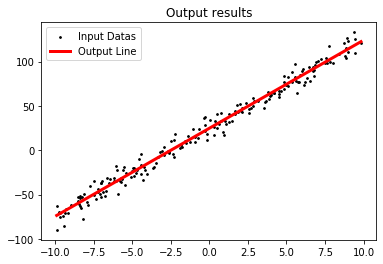

In [49]:
# Plotting the linear regression Result

device = torch.device('cpu')

x_data = x_data.to(device)
y_data = y_data.to(device)

# Output results
plot1 = plt.scatter(x_data, y_data, color='black',marker='o',s=3)
plot2, = plt.plot([min_x_data, max_x_data],[get_y(hth0,hth1,min_x_data),get_y(hth0,hth1,max_x_data)], color='red',linewidth=3)
plot2.LineWidth=1

plt.title("Output results") 
plt.legend([plot1,plot2],["Input Datas","Output Line"])
plt.show()

In [7]:
import collections

Point = collections.namedtuple('Point',['x','y'])
datas = [Point(x,y) for x,y in zip(x_data,y_data)]

# Get -30:30:0.1 tensor
th0s = torch.linspace(start=-30,end=30,steps=601,device='cuda')
th1s = torch.linspace(start=-30,end=30,steps=601,device='cuda')

TH0, TH1 = torch.meshgrid(th0s,th1s)

LOSS = np.zeros(TH0.shape)
TH0 = TH0.to('cuda')
TH1 = TH1.to('cuda')
x_data_ = x_data.to('cuda')
y_data_ = y_data.to('cuda')


# Get Energy values
for i, t0 in enumerate(TH0) :
    for j, t1 in enumerate(TH1) :
        loss = (1/(2*len(y_data)))*torch.sum(((TH0[i,j] + TH1[i,j]*x_data_) - y_data_)**2)
        LOSS[i,j] = loss.item()

start
end


In [11]:
# Setting For Plotting
TH0 = np.array(TH0.cpu())
TH1 = np.array(TH1.cpu())

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
# Setting For Optimization Path Plotting
x_e_line = []
y_e_line = []
z_e_line = []
for i,j in enumerate(epoch_log) :
    idx = i
    x_e_line.append(hth0_log[idx])
    y_e_line.append(hth1_log[idx])
    z_e_line.append(loss_log[idx])

start


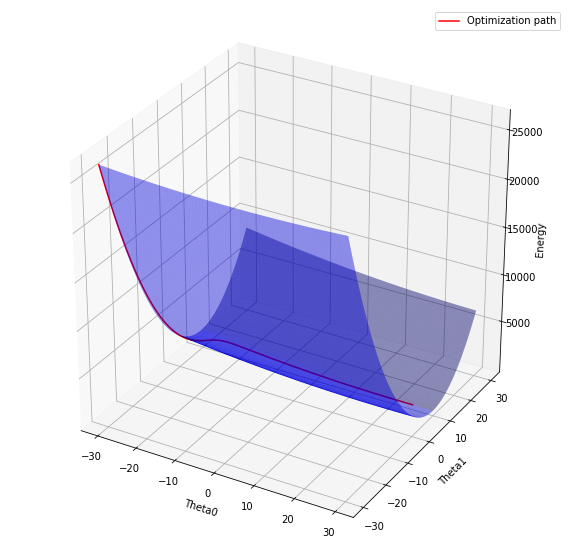

In [46]:
# Plot the gradient descent path on the energy surface
from mpl_toolkits.mplot3d import Axes3D
print("start")

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
ax.plot_surface(TH0,TH1,LOSS,rstride=1,cstride=1,color='b',alpha=0.5)

e_line, = ax.plot(x_e_line,y_e_line,z_e_line,color='red')
ax.legend([e_line],["Optimization path"])
ax.set_xlabel('Theta0')
ax.set_ylabel('Theta1')
ax.set_zlabel('Energy')

plt.show()